# 1. Importing Libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import json
import spacy
from spacy.training import Example
import pickle
import joblib
from google.colab import files

# 2. Data Preprocessing

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/Big Data 17000.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)

# Ensure the column name is 'Description' or replace it if named differently
if 'Description' not in df.columns:
    raise ValueError("The file must have a column named 'Description'.")

# Step 1: Remove digits and special characters (leaving only letters and spaces)
df['CleanDescription'] = df['Description'].str.replace(r'[^a-zA-Z\s]', ' ', regex=True)

# Step 2: Remove all occurrences of 'x' or 'X' from the entire description
df['CleanDescription'] = df['CleanDescription'].str.replace(r'[xX]+', '', regex=True)

# Step 3: Normalize spaces (remove extra spaces caused by cleaning)
df['CleanDescription'] = df['CleanDescription'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Step 4: Extract the first word from the cleaned description
df['FirstWord'] = df['CleanDescription'].str.split().str[0]

# Step 5: Keep only relevant columns
df = df[['Description', 'CleanDescription', 'FirstWord']]

# Step 6: Save the cleaned DataFrame to a CSV file
output_file = '/content/cleaned_data.csv'
df.to_csv(output_file, index=False)

print(f"Cleaned data saved to {output_file}")


Cleaned data saved to /content/cleaned_data.csv


In [ ]:
# Load the CSV file
file_path = '/content/Training Annoted Data.csv'

# Get all unique keys in the 'FirstWord' column
unique_keys = df['FirstWord'].unique()

# Initialize an empty DataFrame to store sampled data
sampled_data = pd.DataFrame()

# Iterate over each unique key and sample up to 500 entries
for key in unique_keys:
    key_data = df[df['FirstWord'] == key]
    key_sampled = key_data.sample(n=min(500, len(key_data)), random_state=42)
    sampled_data = pd.concat([sampled_data, key_sampled])

# Print the number of sampled transactions
print(f"Number of transactions after sampling: {len(sampled_data)}")
print(sampled_data.head())

# Save sampled transactions to a CSV file
sampled_data.to_csv("sampled_data.csv", index=False)


Number of transactions after sampling: 8181
                           Description                    CleanDescription  \
10                   ach ucba razorpay                   ach ucba razorpay   
9          ach ucba protiumfinancelimi         ach ucba protiumfinancelimi   
0   ach cholamandalaminvestm icic nici  ach cholamandalaminvestm icic nici   
8        ach ucba piramalcapitalandhou       ach ucba piramalcapitalandhou   
5           ach ucba finindianclearing          ach ucba finindianclearing   

   FirstWord  
10       ach  
9        ach  
0        ach  
8        ach  
5        ach  


First Word Counts (Total): 908


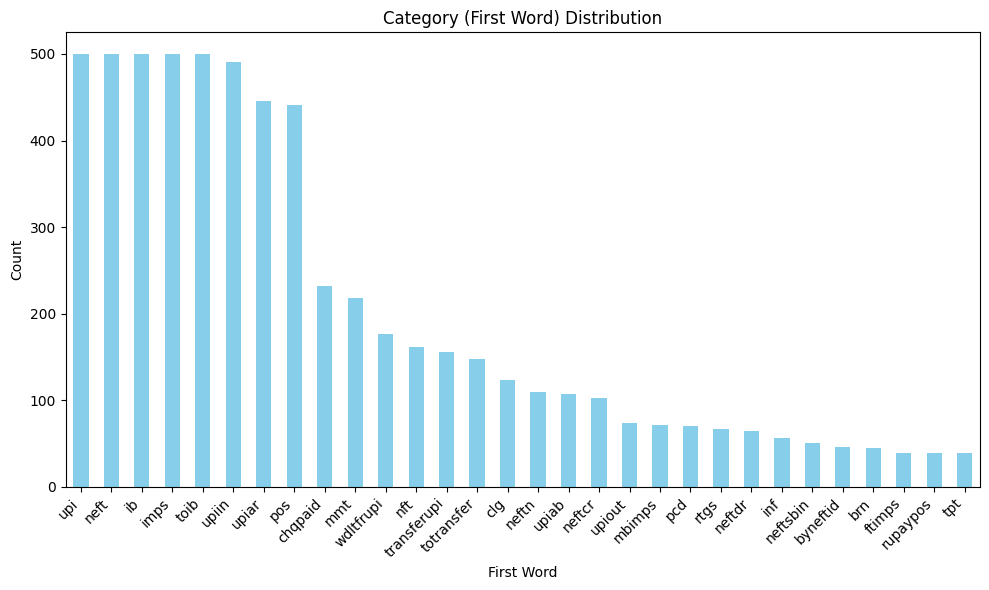

In [ ]:
# Load the CSV file
file_path = '/content/sampled_data.csv'
df = pd.read_csv(file_path)

# Count occurrences of each first word
first_word_counts = df['FirstWord'].value_counts()
top_count = first_word_counts.head(30)

# Output the counts (optional)
print("First Word Counts (Total):", first_word_counts.count())

# Plot the distribution
plt.figure(figsize=(10, 6))
top_count.plot(kind='bar', color='skyblue')
plt.title('Category (First Word) Distribution')
plt.xlabel('First Word')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Load and shuffle the CSV data
csv_path = "/content/test_data2_csv.csv"
data = pd.read_csv(csv_path)
shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Save shuffled data
shuffled_csv_path = "shuffled_data_ready_for_training.csv"
shuffled_data.to_csv(shuffled_csv_path, index=False)
print(f"Shuffled data saved to {shuffled_csv_path}")


Shuffled data saved to shuffled_data_ready_for_training.csv


In [ ]:
# Load the shuffled data
file_path = "/content/shuffled_data_ready_for_training.csv"
df = pd.read_csv(file_path)

# Function to create JSON structure
def validate_and_generate_json(row, id_start, project_id="ner_training_project"):
    text = str(row['Description']).strip()
    name = str(row['Name']).strip()
    if not name or not text or name.lower() not in text.lower():
        return None
    start_idx = text.lower().find(name.lower())
    if start_idx == -1:
        return None
    end_idx = start_idx + len(name)
    return {
        "id": id_start,
        "project_id": project_id,
        "data": {"text": text},
        "annotations": [{"result": [{"id": "annotation_id", "type": "labels", "value": {"start": start_idx, "end": end_idx, "text": text[start_idx:end_idx], "labels": ["Beneficiary Name"]}}]}]
    }

# Generate JSON data
json_output = []
id_start = 31300
for idx, row in df.iterrows():
    json_data = validate_and_generate_json(row, id_start=id_start + idx)
    if json_data:
        json_output.append(json_data)
    else:
        print(f"Skipping row {idx}: Description='{row['Description']}', Name='{row['Name']}'")

# Save to JSON file
output_file_path = 'Training_Json_Data.json'
with open(output_file_path, 'w') as outfile:
    json.dump(json_output, outfile, indent=4)
print(f"JSON file saved to {output_file_path}")


JSON file saved to Training_Json_Data.json


# 3. Model Training

In [ ]:
# 6. Model Training - Data prepare


# Load the exported Label Studio data
with open("/content/Dhwani Final 2 Training.json", "r") as file:
    label_studio_data = json.load(file)

# Prepare training data
TRAINING_DATA = []

# Check if the top-level structure is a list
if isinstance(label_studio_data, list):
    for item in label_studio_data:
        if "data" in item and "text" in item["data"]:
            text = item["data"]["text"]
            entities = []

            # Handle annotations (adjust this part based on actual structure)
            if "annotations" in item:
                for annotation in item["annotations"]:
                    for result in annotation["result"]:
                        if "value" in result and "start" in result["value"] and "end" in result["value"] and "labels" in result["value"]:
                            start = result["value"]["start"]
                            end = result["value"]["end"]
                            label = result["value"]["labels"][0]
                            entities.append((start, end, label))
            TRAINING_DATA.append((text, {"entities": entities}))

else:
    print("Unexpected data format. Please check the structure of the JSON.")

# Verify the training data format
print("Training Data:", TRAINING_DATA)


Training Data: [('upi dr usmanmehbooba bar upi', {'entities': [(7, 20, 'PER')]}), ('upi vandana pytm xx upi', {'entities': [(4, 11, 'PER')]}), ('chqpaid ctsinwardclearingzone lendingkartf', {'entities': [(30, 42, 'PER')]}), ('com pcd bundltechnologies', {'entities': [(8, 25, 'PER')]}), ('neftsbin iitismdhanbad', {'entities': [(9, 22, 'PER')]}), ('pcd jiouniversty mumbai', {'entities': [(4, 16, 'PER')]}), ('wdltfrupi dr milinasa bdbl milinasang upi at sbiofficers qrtrsgokuldham', {'entities': [(13, 21, 'PER')]}), ('imps psintegratese srcb', {'entities': [(5, 18, 'PER')]}), ('imps p a hdfc akppayment', {'entities': [(13, 24, 'PER')]}), ('atl centralavenuepowaim', {'entities': [(4, 17, 'PER')]}), ('nft rajukumar fdrlh idfc', {'entities': [(4, 13, 'PER')]}), ('deposit trf omsaitraders', {'entities': [(12, 24, 'PER')]}), ('totransfer upi dr mohdkal ubin shaikhk uber', {'entities': [(18, 25, 'PER'), (30, 38, 'PER')]}), ('pcd myntradesignspvtltd mumbai', {'entities': [(4, 23, 'PER')]}), ('wdl

In [ ]:
# 6.1. Model Training - Model Training

# Load a blank spaCy model
nlp = spacy.blank("en")

# Create the NER component
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# Add labels to the NER component
for _, annotations in TRAINING_DATA:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Disable other pipeline components during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()

    # Train for 30 iterations
    for iteration in range(30):
        print(f"Starting iteration {iteration}")
        losses = {}
        for text, annotations in TRAINING_DATA:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], drop=0.3, losses=losses)
        print(f"Losses at iteration {iteration}: {losses}")

# Save the trained model
output_dir = "Trained_NER_Model"
nlp.to_disk(output_dir)
print(f"Model saved to {output_dir}")

Starting iteration 0


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "imps p a hdfc akppayment" with entities "[(13, 24, 'PER')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "atl centralavenuepowaim" with entities "[(4, 17, 'PER')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "totransfer upi dr mohdkal ubin shaikhk uber" with entities "[(18, 25, 'PER'), (30, 38, 'PER')]". Use `spacy.tra

Losses at iteration 0: {'ner': 568.2704260350893}
Starting iteration 1
Losses at iteration 1: {'ner': 245.11288284943168}
Starting iteration 2
Losses at iteration 2: {'ner': 136.01983459924222}
Starting iteration 3
Losses at iteration 3: {'ner': 94.28713742362272}
Starting iteration 4
Losses at iteration 4: {'ner': 74.59427086809205}
Starting iteration 5
Losses at iteration 5: {'ner': 63.15244255870652}
Starting iteration 6
Losses at iteration 6: {'ner': 44.851744341284025}
Starting iteration 7
Losses at iteration 7: {'ner': 44.134770838880904}
Starting iteration 8
Losses at iteration 8: {'ner': 31.83276924671981}
Starting iteration 9
Losses at iteration 9: {'ner': 30.42661329353325}
Starting iteration 10
Losses at iteration 10: {'ner': 27.920091809312705}
Starting iteration 11
Losses at iteration 11: {'ner': 31.19071039114848}
Starting iteration 12
Losses at iteration 12: {'ner': 32.47897865027844}
Starting iteration 13
Losses at iteration 13: {'ner': 18.878165010245866}
Starting iter

In [ ]:
# 6.2  Model Training - Model Saving

# Load the saved spaCy NER model
model_dir = "Trained_NER_Model"  # Path to your saved model
nlp = spacy.load(model_dir)

# Save the model using joblib
joblib_file_path = "NER_Model.joblib"
joblib.dump(nlp, joblib_file_path)
print(f"Model saved as a joblib file at {joblib_file_path}")

Model saved as a joblib file at NER_Model.joblib


# 4. Model Testing

In [ ]:
# 7. Model Testing

# Load the saved model using joblib
model_dir = "NER_Model.joblib"  # Adjust this path to where your joblib model is saved
model = joblib.load(model_dir)

# Read the CSV file
test_data = pd.read_csv('/content/shuffled_data_ready_for_training.csv')  # Replace with your CSV file path

# Check that the 'Description' column exists in the CSV
if 'Description' not in test_data.columns:
    print("Error: 'Description' column not found in CSV file.")
else:
    # Prepare a list to store the results
    results = []

    # Process each text entry in the 'Description' column
    for text in test_data['Description'].astype(str).fillna('').tolist():
        if text.strip():  # Proceed only if text is non-empty
            # Use the loaded model for predictions
            doc = model(text)  # Use model to get entities
            for ent in doc.ents:
                results.append({
                    "Description": text,
                    "Entity": ent.text,
                    "Label": ent.label_
                })
        else:
            results.append({
                "Description": text,
                "Entity": "No text found",
                "Label": "N/A"
            })

    # Convert results to a DataFrame
    output_df = pd.DataFrame(results)

    # Save the predicted entities to a CSV file
    output_csv_path = "Predicted_entities_optimized.csv"
    output_df.to_csv(output_csv_path, index=False)

    print(f"Predicted entities saved to {output_csv_path}")

    # If running in a Colab environment, download the generated CSV file
    files.download(output_csv_path)

Predicted entities saved to Predicted_entities_optimized.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#####updated FUll dataset in output

# Load the saved model using joblib
model_dir = "NER_Model.joblib"  # Adjust this path to where your joblib model is saved
model = joblib.load(model_dir)

# Read the CSV file
test_data = pd.read_csv('/content/clean data for testing.xlsx')  # Replace with your CSV file path

# Check that the 'Description' column exists in the CSV
if 'Description' not in test_data.columns:
    print("Error: 'Description' column not found in CSV file.")
else:
    # Print the total count of input data
    print(f"Total number of rows in input data: {len(test_data)}")

    # Prepare a list to store the results
    results = []

    # Process each text entry in the 'Description' column
    for text in test_data['Description'].astype(str).fillna('').tolist():
        if text.strip():  # Proceed only if text is non-empty
            # Use the loaded model for predictions
            doc = model(text)  # Use model to get entities
            if doc.ents:
                # If entities are found, concatenate the entities into a single string
                entities = ", ".join([f"{ent.text}" for ent in doc.ents])
                results.append({
                    "Description": text,
                    "Entity": entities
                })
            else:
                # If no entities are found, add a single row with "No entity"
                results.append({
                    "Description": text,
                    "Entity": "No entity",
                })
        else:
            # Handle cases where text is empty
            results.append({
                "Description": text,
                "Entity": "No text found",
            })

    # Convert results to a DataFrame
    output_df = pd.DataFrame(results)

    # Ensure the output matches the input number of rows (no extra rows)
    print(f"Total number of rows in output data: {len(output_df)}")

    # Save the predicted entities to a CSV file
    output_csv_path = "Predicted_entities_complete.csv"
    output_df.to_csv(output_csv_path, index=False)

    print(f"Predicted entities saved to {output_csv_path}")

    # If running in a Colab environment, download the generated CSV file
    files.download(output_csv_path)



Total number of rows in input data: 456
Total number of rows in output data: 456
Predicted entities saved to Predicted_entities_complete.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>